# Zindi Challenge Project: Churn Prediction for Expresso Customers

### ranked 6 out of 15

Expresso is an African telecommunications company that provides customers with mobile data and calling plans. The objective of this challenge is to develop a self-learning model to predict the probability that each Expresso customer will "leave the network", i.e. become inactive and not perform any transactions (e.g. incoming calls, outgoing calls, mobile data usage, ...) for 90 days.

This solution will help Expresso better serve its customers by understanding which customers are at risk of leaving the network and therefore act accordingly to retain them. 

data source : https://zindi.africa/hackathons/umojahack-senegal-challenge-expresso-sur-la-prediction-dattrition-des-clients-churn/data


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
import category_encoders as ce
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
sns.set()

In [2]:
train = pd.read_csv("../input/train1/Train.csv")
test = pd.read_csv("../input/train2/Test.csv")

In [3]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380127 entries, 0 to 380126
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         380127 non-null  object 
 1   REGION          230399 non-null  object 
 2   TENURE          380127 non-null  object 
 3   MONTANT         247072 non-null  float64
 4   FREQUENCE_RECH  247072 non-null  float64
 5   REVENUE         252754 non-null  float64
 6   ARPU_SEGMENT    252754 non-null  float64
 7   FREQUENCE       252754 non-null  float64
 8   DATA_VOLUME     193087 non-null  float64
 9   ON_NET          241613 non-null  float64
 10  ORANGE          222897 non-null  float64
 11  TIGO            153126 non-null  float64
 12  ZONE1           29861 non-null   float64
 13  ZONE2           24076 non-null   float64
 14  MRG             380127 non-null  object 
 15  REGULARITY      380127 non-null  int64  
 16  TOP_PACK        221348 non-null  object 
 17  FREQ_TOP_P

In [5]:
def change_type(data):
    data.REGULARITY = data.REGULARITY.astype("float32")
    #if "CHURN" in data.columns: data.CHURN = data.CHURN.astype("category")
    data.REGION = data.REGION.astype("category")
    data.TENURE = data.TENURE.astype("category")
    data.TOP_PACK = data.TOP_PACK.astype("category")
    return data

### Data recovery

In [6]:
#train = pd.read_csv("../input/train1/Train.csv")
#test = pd.read_csv("../input/train2/Test.csv")
sampl_submission = pd.read_csv("../input/train3/SampleSubmission.csv")

In [7]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [8]:
train.shape

(2154048, 19)

In [9]:
test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,THIES,K > 24 month,5000.0,5.0,5000.0,1667.0,5.0,NaN,378.0,11.0,5.0,NaN,NaN,NO,42,On-net 1000F=10MilF;10d,5.0
1,000055d41c8a62052dd426592e8a4a3342bf565d,NaN,I 18-21 month,300.0,2.0,326.0,109.0,3.0,397.0,NaN,0.0,NaN,NaN,NaN,NO,41,"Data: 100 F=40MB,24H",1.0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,DAKAR,K > 24 month,3300.0,25.0,3400.0,1133.0,26.0,7150.0,0.0,2.0,5.0,NaN,NaN,NO,57,"Data: 100 F=40MB,24H",22.0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,9,NaN,NaN
4,0000bae5480628cf8fe51ad84bcb39772fc79224,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,10,NaN,NaN


In [10]:
train.MRG.nunique(), test.MRG.nunique()

(1, 1)

In [11]:
train.drop(columns=["MRG"],inplace=True)
test.drop(columns=["MRG"],inplace=True)

In [12]:
train = change_type(train)
test = change_type(test)

### Data cleaning and filling

In [13]:
num_columns = train.select_dtypes(exclude=["object","category"]).columns

In [14]:
num2_columns = test.select_dtypes(exclude=["object","category"]).columns

In [15]:
num_columns

Index(['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
       'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2',
       'REGULARITY', 'FREQ_TOP_PACK', 'CHURN'],
      dtype='object')

### Fill in the missing numerical values with zero: Just a hunch given the data source and the columns.

In [16]:
train[num_columns] = train[num_columns].fillna(0)

In [17]:
test[num2_columns] = test[num2_columns].fillna(0)

### Fill in the missing category values
### Here also the missing categories are either not informed(REGION) or non-existent like the TOP_PACK

In [18]:
# Code brouillon, faites votre travail :)
train['TOP_PACK'] = train['TOP_PACK'].cat.add_categories("NO_TOP_PACK")
train['REGION'] = train['REGION'].cat.add_categories("UNKNOWN")
train['TENURE'] = train['TENURE'].cat.add_categories("UNKNOWN")

test['TOP_PACK'] = test['TOP_PACK'].cat.add_categories("NO_TOP_PACK")
test['REGION'] = test['REGION'].cat.add_categories("UNKNOWN")
test['TENURE'] = test['TENURE'].cat.add_categories("UNKNOWN")

In [19]:
train['TOP_PACK'].fillna("NO_TOP_PACK", inplace=True)
train['REGION'].fillna("UNKNOWN", inplace=True)
train['TENURE'].fillna("UNKNOWN", inplace=True)

test['TOP_PACK'].fillna("NO_TOP_PACK", inplace=True)
test['REGION'].fillna("UNKNOWN", inplace=True)
test['TENURE'].fillna("UNKNOWN", inplace=True)

In [20]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,54.0,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,UNKNOWN,I 18-21 month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NO_TOP_PACK,0.0,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,UNKNOWN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,0.0,90.0,46.0,7.0,0.0,0.0,17.0,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,0.0,0.0,62.0,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,0.0,39.0,24.0,0.0,0.0,0.0,11.0,Mixt 250F=Unlimited_call24H,2.0,0


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 18 columns):
 #   Column          Dtype   
---  ------          -----   
 0   user_id         object  
 1   REGION          category
 2   TENURE          category
 3   MONTANT         float64 
 4   FREQUENCE_RECH  float64 
 5   REVENUE         float64 
 6   ARPU_SEGMENT    float64 
 7   FREQUENCE       float64 
 8   DATA_VOLUME     float64 
 9   ON_NET          float64 
 10  ORANGE          float64 
 11  TIGO            float64 
 12  ZONE1           float64 
 13  ZONE2           float64 
 14  REGULARITY      float32 
 15  TOP_PACK        category
 16  FREQ_TOP_PACK   float64 
 17  CHURN           int64   
dtypes: category(3), float32(1), float64(12), int64(1), object(1)
memory usage: 246.5+ MB


In [22]:
test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,THIES,K > 24 month,5000.0,5.0,5000.0,1667.0,5.0,0.0,378.0,11.0,5.0,0.0,0.0,42.0,On-net 1000F=10MilF;10d,5.0
1,000055d41c8a62052dd426592e8a4a3342bf565d,UNKNOWN,I 18-21 month,300.0,2.0,326.0,109.0,3.0,397.0,0.0,0.0,0.0,0.0,0.0,41.0,"Data: 100 F=40MB,24H",1.0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,DAKAR,K > 24 month,3300.0,25.0,3400.0,1133.0,26.0,7150.0,0.0,2.0,5.0,0.0,0.0,57.0,"Data: 100 F=40MB,24H",22.0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,UNKNOWN,K > 24 month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,NO_TOP_PACK,0.0
4,0000bae5480628cf8fe51ad84bcb39772fc79224,UNKNOWN,K > 24 month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,NO_TOP_PACK,0.0


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380127 entries, 0 to 380126
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   user_id         380127 non-null  object  
 1   REGION          380127 non-null  category
 2   TENURE          380127 non-null  category
 3   MONTANT         380127 non-null  float64 
 4   FREQUENCE_RECH  380127 non-null  float64 
 5   REVENUE         380127 non-null  float64 
 6   ARPU_SEGMENT    380127 non-null  float64 
 7   FREQUENCE       380127 non-null  float64 
 8   DATA_VOLUME     380127 non-null  float64 
 9   ON_NET          380127 non-null  float64 
 10  ORANGE          380127 non-null  float64 
 11  TIGO            380127 non-null  float64 
 12  ZONE1           380127 non-null  float64 
 13  ZONE2           380127 non-null  float64 
 14  REGULARITY      380127 non-null  float32 
 15  TOP_PACK        380127 non-null  category
 16  FREQ_TOP_PACK   380127 non-null  float

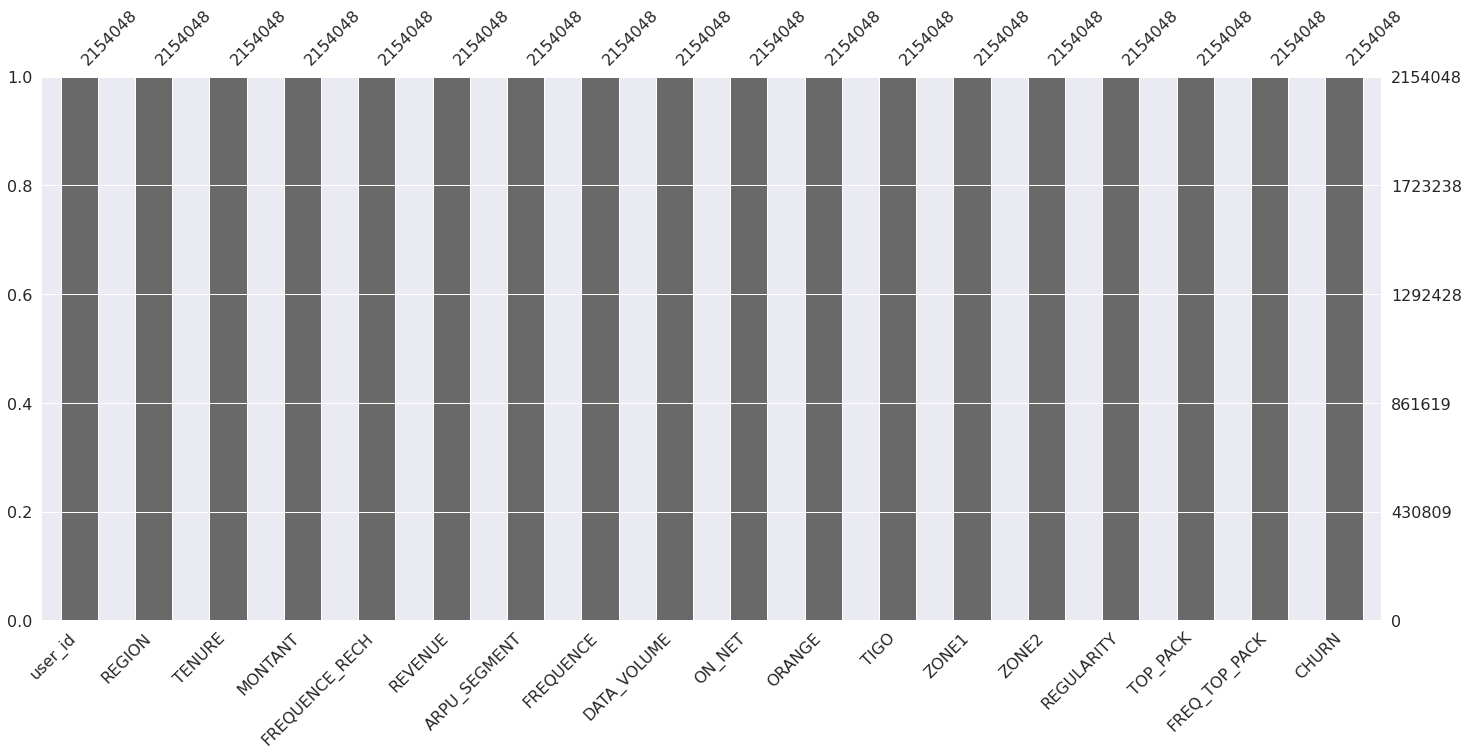

In [24]:
msno.bar(train)

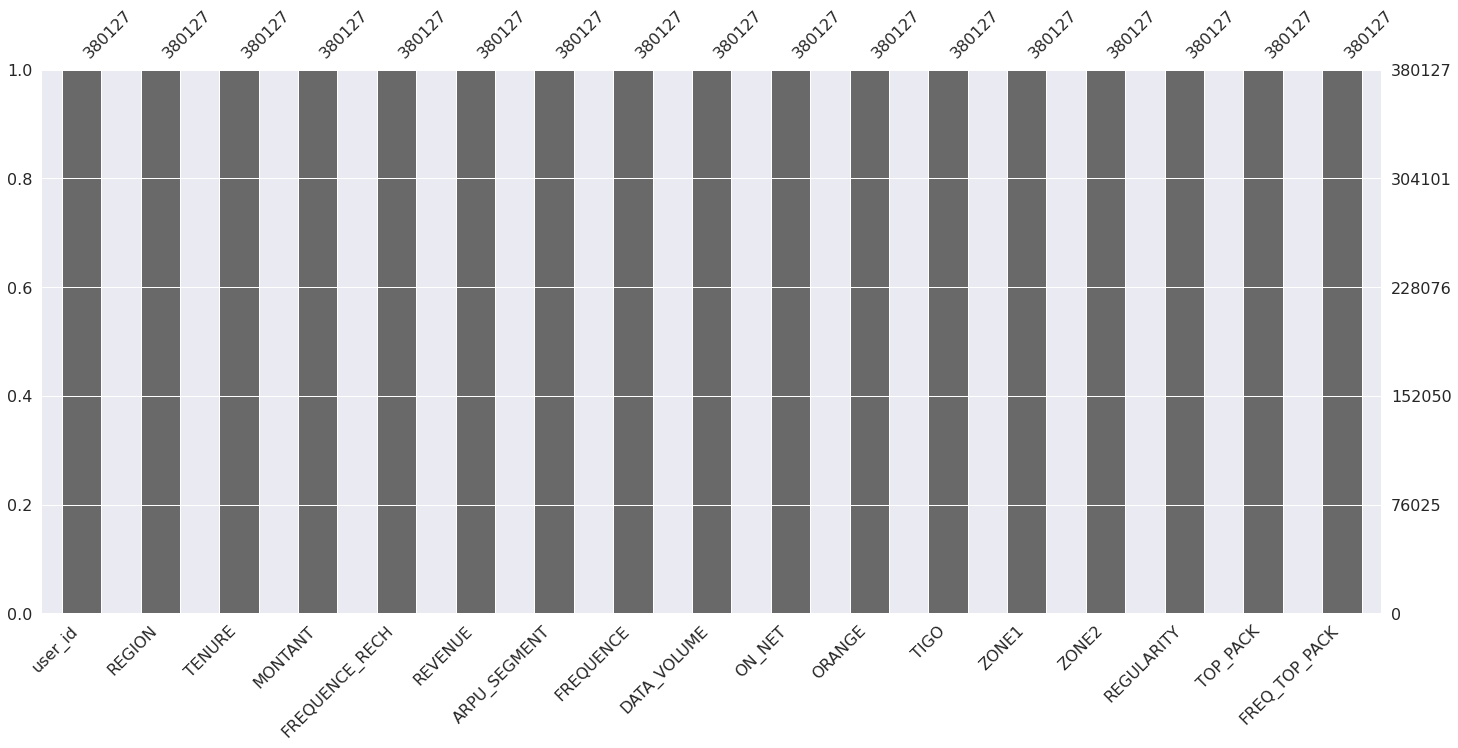

In [25]:
msno.bar(test)

In [26]:
X = train.iloc[:,1:17].values 
y = train.iloc[:,17].values
kaggle_test = test.iloc[:,1:17].values

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 0] = labelencoder_X_1.fit_transform(X[:, 0])
labelencoder_X_2 = LabelEncoder()
X[:, 1] = labelencoder_X_2.fit_transform(X[:, 1])
labelencoder_X_3 = LabelEncoder()
X[:, 14] = labelencoder_X_3.fit_transform(X[:, 14 ])

kaggle_test[:, 0] = labelencoder_X_1.fit_transform(kaggle_test[:, 0])
kaggle_test[:, 1] = labelencoder_X_2.fit_transform(kaggle_test[:, 1])
kaggle_test[:, 14] = labelencoder_X_3.fit_transform(kaggle_test[:, 14])


In [28]:
X_train, X_test, Y_train, Y_test=train_test_split(X, y, test_size=0.2, random_state=42) 

In [29]:
sc=StandardScaler()

In [30]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
kaggle_test=sc.transform(kaggle_test)

In [31]:
X_train.shape

(1723238, 16)

In [32]:
X_test

array([[-1.43111296,  0.21130868,  0.09680259, ..., -0.36099533,
         0.81823143, -0.22913902],
       [ 0.19670825,  0.21130868, -0.41068589, ..., -0.49561451,
         0.95063377, -0.42097085],
       [ 0.92018435,  0.21130868, -0.56927605, ..., -1.1687104 ,
         0.73879003, -0.51688676],
       ...,
       [ 0.92018435, -2.78086156, -0.56927605, ..., -1.1687104 ,
         0.73879003, -0.51688676],
       [-1.43111296,  0.21130868, -0.41068589, ..., -0.13663004,
        -1.14132316, -0.42097085],
       [ 0.92018435,  0.21130868, -0.56927605, ..., -1.07896428,
         0.73879003, -0.51688676]])

In [33]:
kaggle_test

array([[ 7.39315325e-01,  2.11308681e-01,  2.23674717e-01, ...,
         6.26211970e-01, -2.66306308e-03, -3.73071945e-02],
       [ 9.20184349e-01, -2.78086156e+00, -5.21699000e-01, ...,
         5.81338911e-01, -1.59149111e+00, -4.20970846e-01],
       [-1.43111296e+00,  2.11308681e-01, -4.59285425e-02, ...,
         1.29930786e+00, -1.59149111e+00,  1.59326332e+00],
       ...,
       [ 9.20184349e-01,  2.11308681e-01,  5.71550567e-02, ...,
        -5.85360627e-01, -7.70596620e-01,  5.86087183e-02],
       [ 9.20184349e-01,  2.11308681e-01,  4.12960415e-02, ...,
         4.28622009e-02, -1.59149111e+00,  5.38188282e-01],
       [-1.25024394e+00,  2.11308681e-01, -5.69276046e-01, ...,
        -3.60995332e-01, -1.08584933e-01, -5.16886759e-01]])

In [34]:
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train).view(-1,1)

X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test).view(-1,1)
kaggle_test = torch.from_numpy(kaggle_test)



In [35]:
train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
val_ds = torch.utils.data.TensorDataset(X_test, Y_test)


In [36]:
batch_size=128

In [37]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [38]:
class ChurnModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 32)
        self.linear4 = nn.Linear(32, 32)
        # output layer
        self.linear5 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return nn.Sigmoid()(out)

In [39]:
in_size = 16
hidden_size = 64 # you can change this
out_size = 1

In [40]:
model = ChurnModel(in_size, hidden_size, out_size)

In [41]:
import torch.optim as optim
# specify loss function
loss_fn = nn.BCELoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9,nesterov = True)

In [42]:
epochs = 20

# Some lists to keep track of loss and accuracy during each epoch
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Set the training mode ON -> Activate Dropout Layers
model.train() # prepare model for training



ChurnModel(
  (linear1): Linear(in_features=16, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=1, bias=True)
)

In [43]:
for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    # Calculate Accuracy         
    correct = 0
    total = 0
    for data,target in train_loader:
        data = Variable(data).float()
        target = Variable(target).type(torch.FloatTensor)
        #print("Target = ",target[0].item())
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        predicted = (torch.round(output.data[0]))
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += torch.sum(predicted == target).item()

        # calculate the loss
        loss = loss_fn(output,target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    # calculate average training loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    # Avg Accuracy
    accuracy = 100 *torch.tensor(correct / float(total)) 
    # Put them in their list
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.4f}\t Acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # Move to next epoch
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 0.2695	 Acc: 70.01%
Epoch: 2 	Training Loss: 0.2574	 Acc: 70.35%
Epoch: 3 	Training Loss: 0.2558	 Acc: 69.84%
Epoch: 4 	Training Loss: 0.2551	 Acc: 70.09%
Epoch: 5 	Training Loss: 0.2548	 Acc: 70.24%
Epoch: 6 	Training Loss: 0.2545	 Acc: 70.25%
Epoch: 7 	Training Loss: 0.2543	 Acc: 70.15%
Epoch: 8 	Training Loss: 0.2542	 Acc: 69.96%
Epoch: 9 	Training Loss: 0.2541	 Acc: 70.33%
Epoch: 10 	Training Loss: 0.2540	 Acc: 70.49%
Epoch: 11 	Training Loss: 0.2539	 Acc: 70.24%
Epoch: 12 	Training Loss: 0.2538	 Acc: 70.20%
Epoch: 13 	Training Loss: 0.2537	 Acc: 70.28%
Epoch: 14 	Training Loss: 0.2536	 Acc: 70.20%
Epoch: 15 	Training Loss: 0.2536	 Acc: 69.95%
Epoch: 16 	Training Loss: 0.2536	 Acc: 70.06%
Epoch: 17 	Training Loss: 0.2535	 Acc: 69.90%
Epoch: 18 	Training Loss: 0.2535	 Acc: 69.63%
Epoch: 19 	Training Loss: 0.2534	 Acc: 70.04%
Epoch: 20 	Training Loss: 0.2534	 Acc: 70.15%


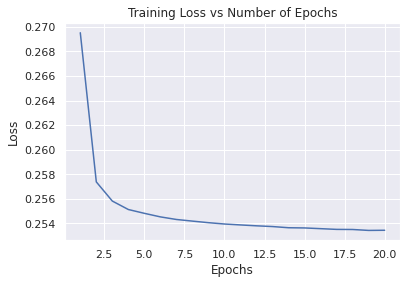

In [45]:
plt.plot(epoch_list,train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Number of Epochs")
plt.show()

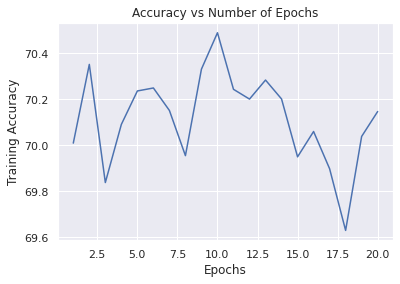

In [46]:
plt.plot(epoch_list,train_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.show()

In [47]:
correct = 0
total = 0
val_loss = 0
model.eval() # Required for Evaluation/Test
with torch.no_grad():
    for data, target in val_loader:

        # Convert our images and labels to Variables to accumulate Gradients
        data = Variable(data).float()
        target = Variable(target).type(torch.FloatTensor)

        # Predict Output
        output = model(data)

        # Calculate Loss
        loss = loss_fn(output, target)
        val_loss += loss.item()*data.size(0)
        # Get predictions from the maximum value
        predicted = (torch.round(output.data[0]))

        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(val_loader.dataset)
    accuracy = 100 * correct/ float(total)
print("Accuracy = ",accuracy.item() * 0.01)

Accuracy =  0.6980501556396485


In [48]:
kaggle_test = Variable(kaggle_test).float()


In [59]:
# Predicted Labels will be stored here
results = []

# Set Evaluation Mode ON -> Turn Off Dropout
model.eval() # Required for Evaluation/Test

with torch.no_grad():
    for data in kaggle_test:
        output = model(data)
        #pred = int((torch.round(output.data[0])).item())
        results.append(output)

In [52]:
import numpy as np

In [60]:
results = np.array(results)

In [72]:
df_submission = pd.DataFrame()
df_submission["user_id"] = test.user_id
df_submission["CHURN"] = results 
df_submission.to_csv('submission1.csv')

In [73]:
df_submission.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0.001593
1,000055d41c8a62052dd426592e8a4a3342bf565d,0.049833
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0.000834
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0.380877
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0.369690
